<a href="https://colab.research.google.com/github/Max-We/sf-zero-signal-to-noise/blob/main/compare_common_diffusion_noise_schedulers_are_flawed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -Uq diffusers transformers fastcore

In [6]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image
from IPython.display import display

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Stable Diffusion
## Setup

In [7]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from tqdm.auto import tqdm

In [8]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [9]:
prompts = [
    "Solid black background",
    #  "Dark city at night" , 
     "A photograph of an astronaut riding a horse", 
    #  "A photograph of a sunny day in central park",
     "A starry sky",
     ]
height, width = 512, 512

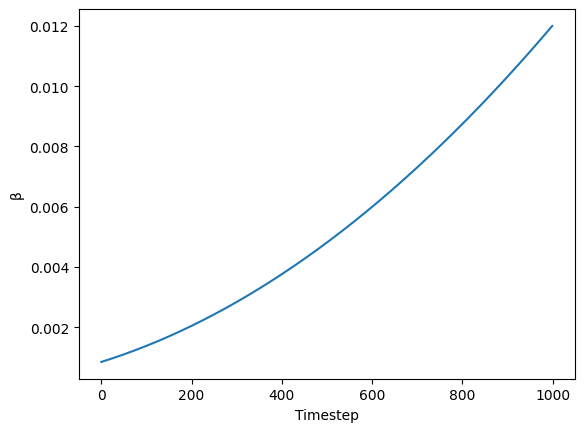

In [10]:
beta_start,beta_end = 0.00085,0.012
train_timesteps, timesteps = 1000, 75
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β');

In [11]:
scheduler = PNDMScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=train_timesteps)

In [12]:
scheduler.set_timesteps(timesteps)

In [13]:
scheduler.timesteps

tensor([962, 955, 955, 949, 949, 942, 942, 936, 936, 929, 929, 923, 923, 910,
        897, 884, 871, 858, 845, 832, 819, 806, 793, 780, 767, 754, 741, 728,
        715, 702, 689, 676, 663, 650, 637, 624, 611, 598, 585, 572, 559, 546,
        533, 520, 507, 494, 481, 468, 455, 442, 429, 416, 403, 390, 377, 364,
        351, 338, 325, 312, 299, 286, 273, 260, 247, 234, 221, 208, 195, 182,
        169, 156, 143, 130, 117, 104,  91,  78,  65,  52,  39,  26,  13,   0])

In [14]:
scheduler.betas

tensor([0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0015, 

## Normal Inference

In [15]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [16]:
def mk_samples(prompt, scheduler, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.config.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [17]:
images = mk_samples(prompts, scheduler)


  0%|          | 0/79 [00:00<?, ?it/s]

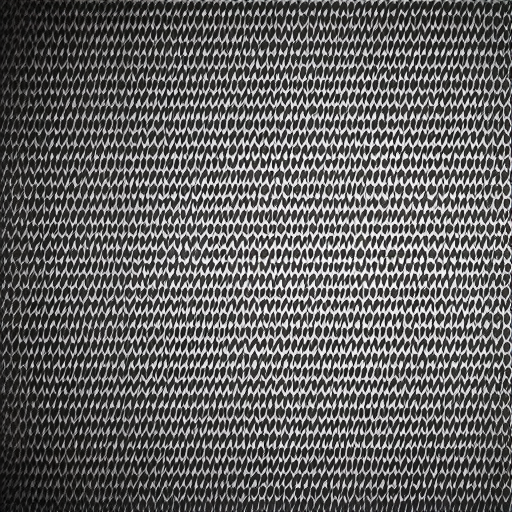

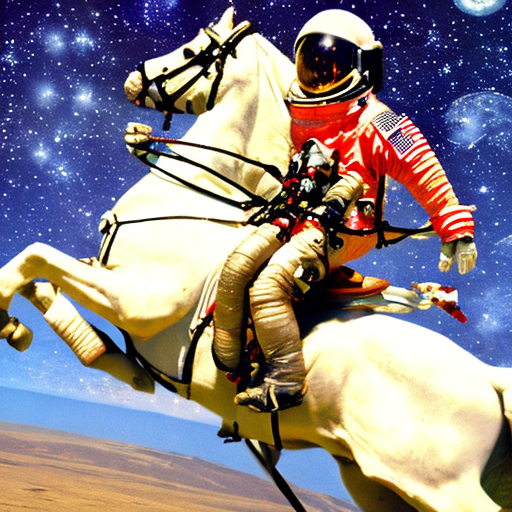

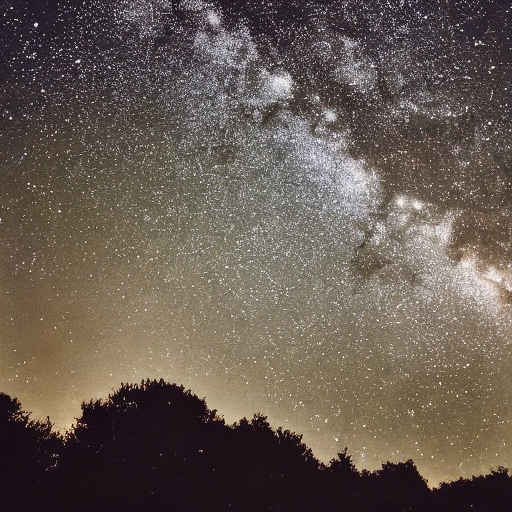

In [18]:
for img in images: display(mk_img(img))

## Zero Signal-to-Noise Ratio

Create custom betas to use

In [19]:
def compare_slope(betas):
    # Calculate alpha-bar-sqrt
    alphas = 1 - betas
    alphas_bar = alphas.cumprod(0)
    alphas_bar_sqrt = alphas_bar.sqrt()
    original = alphas_bar_sqrt.clone()

    # Store old values.
    alphas_bar_sqrt_0 = alphas_bar_sqrt[0].clone()
    alphas_bar_sqrt_T = alphas_bar_sqrt[-1].clone()

    # Shift so the last timestep is zero.
    alphas_bar_sqrt -= alphas_bar_sqrt_T

    # Scale so the first timestep is back to the old value.
    alphas_bar_sqrt *= alphas_bar_sqrt_0 / (alphas_bar_sqrt_0 - alphas_bar_sqrt_T)

    # Compare
    # plt.plot(custom_betas, label="snr")
    plt.plot(original, label="original")
    plt.plot(alphas_bar_sqrt, label="modifier")
    plt.legend()
    plt.xlabel('Timestep')
    plt.ylabel('β');

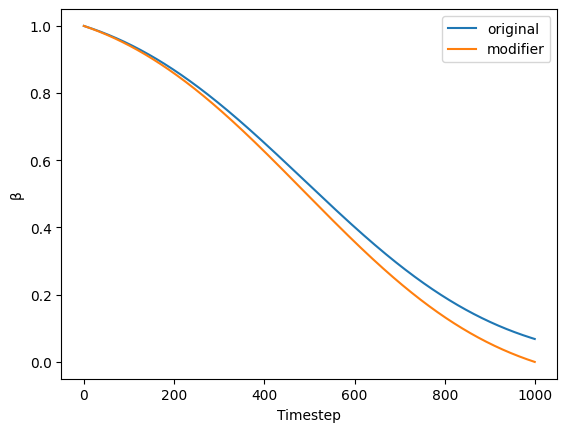

In [20]:
compare_slope(scheduler.betas)

In [ ]:
def enforce_zero_terminal_snr(betas):
    # Convert betas to alphas_bar_sqrt
    alphas = 1 - betas
    alphas_bar = alphas.cumprod(0)
    alphas_bar_sqrt = alphas_bar.sqrt()

    # Store old values.
    alphas_bar_sqrt_0 = alphas_bar_sqrt[0].clone()
    alphas_bar_sqrt_T = alphas_bar_sqrt[-1].clone()

    # Shift so the last timestep is zero.
    alphas_bar_sqrt -= alphas_bar_sqrt_T

    # Scale so the first timestep is back to the old value.
    alphas_bar_sqrt *= alphas_bar_sqrt_0 / (alphas_bar_sqrt_0 - alphas_bar_sqrt_T)

    # Convert alphas_bar_sqrt to betas
    alphas_bar = alphas_bar_sqrt ** 2
    alphas = alphas_bar[1:] / alphas_bar[:-1]
    alphas = torch.cat([alphas_bar[0:1], alphas])
    betas = 1 - alphas

    return betas

In [ ]:
custom_betas = enforce_zero_terminal_snr(scheduler.betas)

In [ ]:
# plt.plot(custom_betas, label="snr")
# plt.plot(scheduler.betas, label="default")
# plt.legend()
# plt.xlabel('Timestep')
# plt.ylabel('β');

`PNDMScheduler` provides a parameter `trained_betas` to pass the betas directly

In [ ]:
scheduler_snr = PNDMScheduler(trained_betas=custom_betas, num_train_timesteps=train_timesteps)

/usr/local/lib/python3.10/dist-packages/diffusers/schedulers/scheduling_pndm.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.betas = torch.tensor(trained_betas, dtype=torch.float32)


In [ ]:
images_snr = mk_samples(prompts, scheduler_snr)

  0%|          | 0/79 [00:00<?, ?it/s]

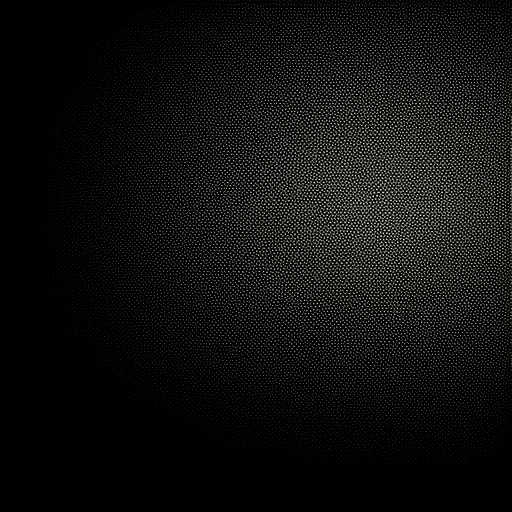

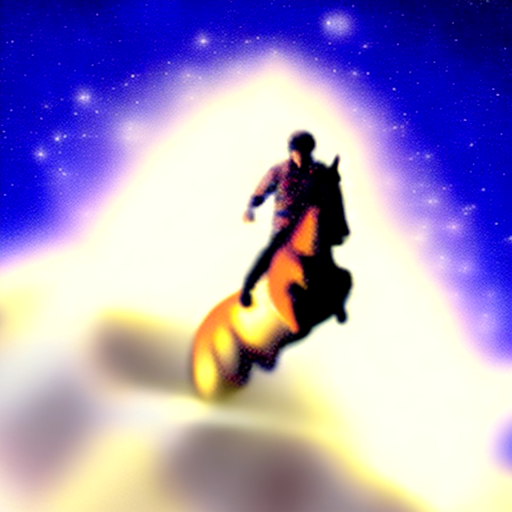

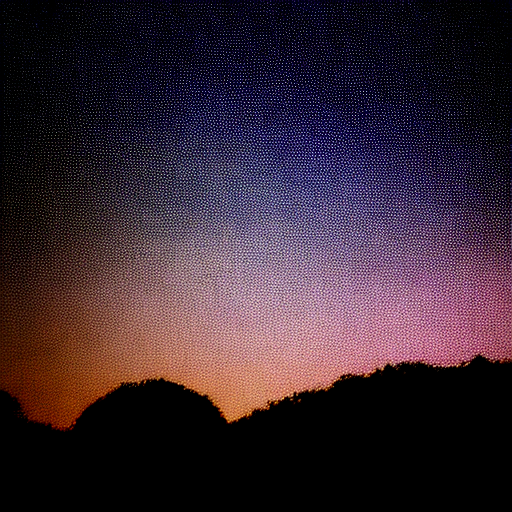

In [ ]:
for img in images_snr: display(mk_img(img))

## Running via pipeline

In [ ]:
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, scheduler=scheduler).to("cuda")
# pipe_snr = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, scheduler=scheduler_snr).to("cuda")

In [ ]:
# images_pipe = pipe(prompts)
# images_pipe_snr = pipe_snr(prompts)

In [ ]:
# for img in images_pipe: display(mk_img(img))

In [ ]:
# for img in images_pipe_snr: display(mk_img(img))